# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/sound_classifier /mydrive

# navigate to the working directory
%cd /mydrive

ln: failed to create symbolic link '/mydrive/sound_classifier': File exists
/content/gdrive/My Drive/Colab Notebooks/sound_classifier


## Import libraries

In [3]:
import numpy as np
import pandas as pd
import os
from os.path import basename
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display
import IPython.display as display
import tqdm.notebook as tq

# Dataset
Environment Sound Classification

## Import

In [4]:
# !git clone https://github.com/karolpiczak/ESC-50.git

In [5]:
# path to csv file containing meta data for the dataset
META_CSV = './ESC-50/meta/esc50.csv'

# path to folder containing audio files
AUDIO_PATH = './ESC-50/audio/'

In [6]:
df = pd.read_csv(META_CSV)
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


# Helper functions

In [7]:
def plot_signal_and_spectogram(data_array, samplerate):
    fig, axs = plt.subplots(1, 2, figsize=(22, 5))
    fig.subplots_adjust(hspace = .1, wspace=.2)
    axs = axs.ravel()
    x = range(len(data_array))
    y = data_array
    axs[0].plot(x, y)
    axs[0].grid()
    axs[1].specgram(data_array,Fs=samplerate, mode='psd', scale='dB')
    axs[0].set_title('Signal')
    axs[0].set_xlabel('Sample')
    axs[0].set_ylabel('Amplitude')
    axs[1].set_title('Spectogram')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Frequency')
    plt.grid()

def save_spectogram(filename):

    filepath = AUDIO_PATH+filename
    spectogram_path = SPECTOGRAM_PATH+filename.split('.')[0]+'.png'
    
    if not os.path.exists(spectogram_path):

      clip, sample_rate = librosa.load(
        filepath,
        sr=None
        )
      
      plt.specgram(
          clip,
          Fs=sample_rate,
          mode='psd',
          scale='dB'
          )
      
      plt.axis('off')

      plt.savefig(
          spectogram_path,
          bbox_inches = 'tight',
          pad_inches = 0
          )
    
def listen_example(filepath):
    return display.Audio(filepath)

def get_file_list(category):
    file_list = data[data['category']==category]['filename'].to_list()
    return file_list

# Exploratory Data Analysis

## Categories

In [8]:
df.groupby('category').size()

category
airplane            40
breathing           40
brushing_teeth      40
can_opening         40
car_horn            40
cat                 40
chainsaw            40
chirping_birds      40
church_bells        40
clapping            40
clock_alarm         40
clock_tick          40
coughing            40
cow                 40
crackling_fire      40
crickets            40
crow                40
crying_baby         40
dog                 40
door_wood_creaks    40
door_wood_knock     40
drinking_sipping    40
engine              40
fireworks           40
footsteps           40
frog                40
glass_breaking      40
hand_saw            40
helicopter          40
hen                 40
insects             40
keyboard_typing     40
laughing            40
mouse_click         40
pig                 40
pouring_water       40
rain                40
rooster             40
sea_waves           40
sheep               40
siren               40
sneezing            40
snoring             40
th

## Sample file

In [9]:
# generate random integer
random_int = np.random.randint(0, high=df.shape[0])
# select a  row
row = df.iloc[random_int]
# generate a filepath
filepath = AUDIO_PATH+row['filename']

# open the audio file
clip, sample_rate = librosa.load(filepath, sr=None)

print('Category:     {}'.format(row['category']))
print('Sample Rate   {} Hz'.format(sample_rate))
print('Clip Length   {:3.2f} seconds'.format(len(clip)/sample_rate))

Category:     keyboard_typing
Sample Rate   44100 Hz
Clip Length   5.00 seconds


## Preview audio

In [10]:
listen_example(filepath)

## Signal & spectogram

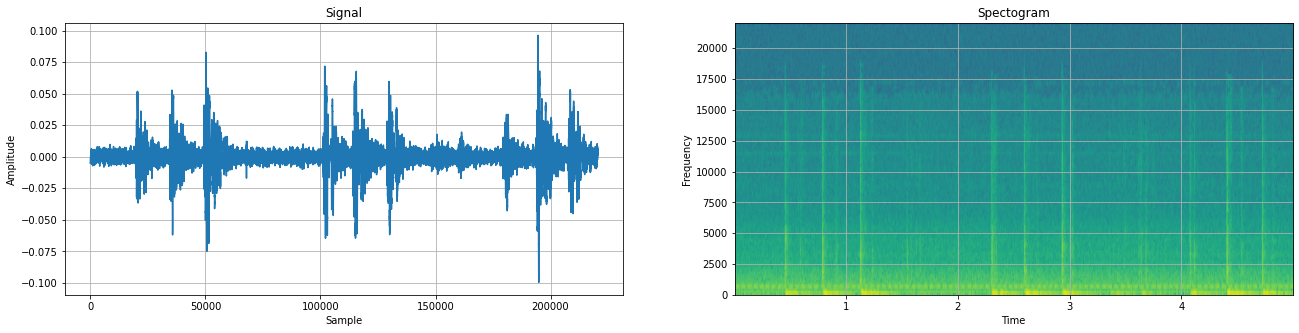

In [11]:
plot_signal_and_spectogram(clip, sample_rate)

# Preprocessing

## Save spectograms

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


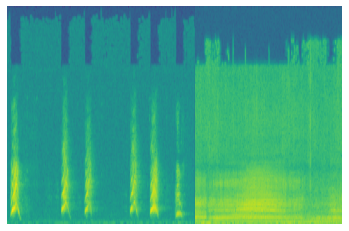

In [12]:
# path to folder containing audio files
SPECTOGRAM_PATH = './ESC-50/spectogram/'

# save a spectogram representation for each audio file
for filename in tq.tqdm(df['filename']):
  save_spectogram(filename)